In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotnine as p9
import random

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor


pd.options.display.max_columns= None


from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Raleway']

In [142]:
data = pd.read_csv('barkbeetle_dataset.csv')

data['timestamp'] = pd.to_datetime(data['timestamp'])

In [143]:
# TODO: move to other notebook
data['area_endangered'] = data[['forest_ownership', 'area_nse', 'area_se']].apply(lambda x: x[1] if x[0] == 'NSW' else x[2], axis=1)

In [144]:
# TODO: remove pre 2006 and post feb2020 
data = data[data['timestamp'].isin(pd.date_range(start='2006-01-01', end='2020-02-29', freq='M'))]

In [146]:
# aggregate NSW and SW
data[['infested_wood', 'area_endangered', 'prev_infested_wood', 'prev_infested_wood_rollsr', 'prev_infested_wood_rollwr']]= data.groupby(['timestamp', 'fdist_newname'])[['infested_wood', 'area_endangered', 'prev_infested_wood', 'prev_infested_wood_rollsr', 'prev_infested_wood_rollwr']].transform('sum')
data.drop_duplicates(['timestamp', 'fdist_newname'], inplace=True, ignore_index=True)

data['id'] = data['id'].map(lambda x: '-'.join(x.split('-')[:2]))

In [147]:
# pre-filter for features and train test split to prevent data leakage
y = data['infested_wood']
X = data[['timeframe', 'id', 'area_endangered', 'timestamp', 'centroid_xcoord', 'centroid_ycoord', 
          'TM0', 'RGK', 'KWK', 'prev_infested_wood', 'TM0_rollsr', 'RGK_rollsr', 'KWK_rollsr', 'prev_infested_wood_rollsr', 'TM0_rollwr', 'RGK_rollwr', 'KWK_rollwr', 'prev_infested_wood_rollwr']]

In [148]:
X.head()

,timeframe,id,area_endangered,timestamp,centroid_xcoord,centroid_ycoord,TM0,RGK,KWK,prev_infested_wood,TM0_rollsr,RGK_rollsr,KWK_rollsr,prev_infested_wood_rollsr,TM0_rollwr,RGK_rollwr,KWK_rollwr,prev_infested_wood_rollwr
0,06 Juni,Bautzen-Elsterheide,38.22,2007-06-30,451775.13571,5.704409e+06,18.961279,150.442419,-37.537037,0.0,17.260886,144.731032,-52.174580,0.0,2.251927,42.071269,27.894333,0.0
1,08 August,Bautzen-Elsterheide,38.22,2007-08-31,451775.13571,5.704409e+06,18.506060,133.832676,-43.587545,0.0,16.749046,139.227836,-41.574411,5.0,2.251927,42.071269,27.894333,5.0
2,10 Oktober-Dezember,Bautzen-Elsterheide,38.22,2007-12-31,451775.13571,5.704409e+06,4.503592,97.931986,76.421211,0.0,16.047250,134.313302,-26.482604,17.0,1.637392,39.827834,29.652133,17.0
3,04 April,Bautzen-Elsterheide,38.22,2008-04-30,451775.13571,5.704409e+06,8.478114,92.019860,18.926935,0.0,15.610550,125.470429,-8.399103,19.0,1.487336,39.425702,29.043379,19.0
4,06 Juni,Bautzen-Elsterheide,38.22,2008-06-30,451775.13571,5.704409e+06,18.144107,168.693261,-60.718184,0.0,15.309315,128.660270,-26.172728,20.0,1.487336,39.425702,29.043379,20.0


## train-val-test split

In [149]:
train_ratio = 0.80
val_ratio = 0.10
test_ratio = 0.10

# make train set according to train_ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=1 - train_ratio, 
                                                    random_state=0)

# make validation and test set according to val_ratio and test_ratio
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                test_size=test_ratio/(test_ratio + val_ratio), 
                                                random_state=0, 
                                                shuffle=False)  # shuffle already done in first split

# Show the results of the split
print ('Training set has {} samples.'.format(X_train.shape[0]))
print ('Validation set has {} samples.'.format(X_val.shape[0]))
print ('Testing set has {} samples.'.format(X_test.shape[0]))

Training set has 4757 samples.
Validation set has 595 samples.
Testing set has 595 samples.


In [150]:
# remove and save ids and timestamps from the sets
# can be used to show model predictions later 
id_train, ts_train = X_train.pop('id'), X_train.pop('timestamp')
id_val, ts_val = X_val.pop('id'), X_val.pop('timestamp')
id_test, ts_test = X_test.pop('id'), X_test.pop('timestamp')

## Engineer Month Feature

In [151]:
# TODO: diese Funktion als custom pipeline

def month_num_encoder(X_train, y_train, X_val, X_test):
    '''
    TODO: documentation
    '''
        
    # get a factor for every timeframe
    # factor = how much of the yearly infestation was observed in the respective timeframe
    
    # merge timeframe column from X_train with y_train (target)
    tf_y = pd.DataFrame({'timeframe': X_train['timeframe'], 'target': y_train})
    
    # group by timeframe and take the mean of target
    tf_y = tf_y.groupby('timeframe').mean()
    
    # get the sum of all groups
    total = tf_y['target'].sum()
    
    # make a dictionary that maps the timeframe to the ratio it contributes to the target on average
    transform_dict = tf_y['target'].map(lambda x: x/total).to_dict()
    
    # use these factors (one numerical feature) in train, val and test sets
    # instead of the timeframe feature (categorial with 8 categories)
    # since we only used the knowledge on our targets of the train set (y_train) there is no data leakage 
    
    new_X_train = X_train.copy()
    new_X_train['timeframe'] = new_X_train['timeframe'].map(lambda x: transform_dict.get(x))
    new_X_val = X_val.copy()
    new_X_val['timeframe'] = new_X_val['timeframe'].map(lambda x: transform_dict.get(x))
    new_X_test = X_test.copy()
    new_X_test['timeframe'] = new_X_test['timeframe'].map(lambda x: transform_dict.get(x))
    
    return new_X_train, new_X_val, new_X_test

In [152]:
# use function to encode the months in timeframe column
X_train, X_val, X_test = month_num_encoder(X_train, y_train, X_val, X_test)

In [153]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4757 entries, 5589 to 2732
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   timeframe                  4757 non-null   float64
 1   area_endangered            4757 non-null   float64
 2   centroid_xcoord            4757 non-null   float64
 3   centroid_ycoord            4757 non-null   float64
 4   TM0                        4757 non-null   float64
 5   RGK                        4757 non-null   float64
 6   KWK                        4757 non-null   float64
 7   prev_infested_wood         4757 non-null   float64
 8   TM0_rollsr                 4750 non-null   float64
 9   RGK_rollsr                 4750 non-null   float64
 10  KWK_rollsr                 4750 non-null   float64
 11  prev_infested_wood_rollsr  4757 non-null   float64
 12  TM0_rollwr                 4750 non-null   float64
 13  RGK_rollwr                 4750 non-null   fl

## Pipeline

In [154]:
# Creating list for categorical predictors/features 
# Should not have any but we leave it in for robustness sake (TODO:remove)
cat_features = list(X_train.columns[X_train.dtypes==object])
print(f'Categorical features: {cat_features}')

# Creating list for numerical predictors/features
# Since 'Survived' is our target variable we will exclude this feature from this list of numerical predictors 
num_features = list(X_train.columns[X_train.dtypes!=object])
print(f'Numerical features: {num_features}')

Categorical features: []
Numerical features: ['timeframe', 'area_endangered', 'centroid_xcoord', 'centroid_ycoord', 'TM0', 'RGK', 'KWK', 'prev_infested_wood', 'TM0_rollsr', 'RGK_rollsr', 'KWK_rollsr', 'prev_infested_wood_rollsr', 'TM0_rollwr', 'RGK_rollwr', 'KWK_rollwr', 'prev_infested_wood_rollwr']


In [155]:
# Pipline for numerical features
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    # ('std_scaler', StandardScaler()) # Standardscaler not needed for now as we use Decision Tree Based Models
])

# Pipeline for categorical features 
# don't have those for now but keep it in for robustness' sake
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

# Complete pipeline for numerical and categorical features
# 'ColumnTranformer' applies transformers (num_pipeline/ cat_pipeline)
# to specific columns of an array or DataFrame (num_features/cat_features)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [156]:
# Building a full pipeline with our preprocessor and a Regressor
pipe_xgbr = Pipeline([
    ('preprocessor', preprocessor),
    ('xgbr', XGBRegressor(objective='reg:squarederror'))
])

In [157]:
# Making predictions on the training set using cross validation
# cross_val_predict expects an estimator (model), X, y and nr of cv-splits (cv)
y_train_predicted = cross_val_predict(pipe_xgbr, X_train, y_train, cv=5)

In [158]:
# Calculating the mean sqaured error, mean absolute error and explained variance for XGBRegressor
print('Cross validation scores:')
print('-------------------------')
print("MSE: {:.2f}".format(mean_squared_error(y_train, y_train_predicted)))
print("MAE: {:.2f}".format(mean_absolute_error(y_train, y_train_predicted)))
print("Explained Variance: {:.2f}".format(explained_variance_score(y_train, y_train_predicted)))

Cross validation scores:
-------------------------
MSE: 5510572.35
MAE: 403.49
Explained Variance: 0.43


In [159]:
# optimizing - defining parameter space for search
param_xgbr = {"xgbr__learning_rate"    : [0.02, 0.05, 0.10, 0.15, 0.20] ,
              "xgbr__max_depth"        : [2, 3, 4, 5, 6, 8, 10, 12],
              "xgbr__subsample"        : [0.5, 0.75, 1],
              "xgbr__min_child_weight" : [1, 2, 3, 4, 5],
              "xgbr__gamma"            : [0.0, 0.05, 0.1, 0.2 , 0.3],
              "xgbr__colsample_bytree" : [0.4, 0.5 , 0.7, 0.8, 1, 1.2],
              'xgbr__n_estimators'     : [100, 150, 200, 250, 300]
             }

# specify search hyperparameters
grid_xgbr = RandomizedSearchCV(pipe_xgbr, param_distributions=param_xgbr, cv=4, scoring='neg_mean_squared_error', 
                           verbose=1, n_jobs=-1, random_state=0, n_iter=2000)

In [160]:
grid_xgbr.fit(X_train, y_train)

Fitting 4 folds for each of 2000 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:  6.1min finished


RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer_num',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               ['timeframe',
                                                                                'area_endangered',
                                                                                'centroid_xcoord',
                                                                                'centroid_ycoord',
                                                                                'TM0',
                                                                                'RGK',
                   

In [161]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_xgbr.best_score_))
print("Best parameters:\n{}".format(grid_xgbr.best_params_))

Best score:
-3755213.18
Best parameters:
{'xgbr__subsample': 0.5, 'xgbr__n_estimators': 100, 'xgbr__min_child_weight': 2, 'xgbr__max_depth': 12, 'xgbr__learning_rate': 0.05, 'xgbr__gamma': 0.2, 'xgbr__colsample_bytree': 1}


In [162]:
# Save best model as best_model
best_model = grid_xgbr.best_estimator_['xgbr']

In [163]:
# Preparing the validation set 

# fitting our preprocessing pipeline only with training data
preprocessor.fit(X_train)
# transforming our test data with fitted preprocessor pipeline
X_train_preprocessed = preprocessor.transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)

In [164]:
# Calculating the mean sqaured error, mean absolute error and explained variance for the optimized XGBRegressor
y_val_pred = best_model.predict(X_val_preprocessed)
y_train_pred = best_model.predict(X_train_preprocessed)

print("MSE: {:.2f}".format(mean_squared_error(y_val, y_val_pred)))
print("MAE: {:.2f}".format(mean_absolute_error(y_val, y_val_pred)))
print("Explained Variance: {:.2f}".format(explained_variance_score(y_val, y_val_pred)))
# TODO: F1-score in regression?

MSE: 393873.99
MAE: 174.97
Explained Variance: 0.81


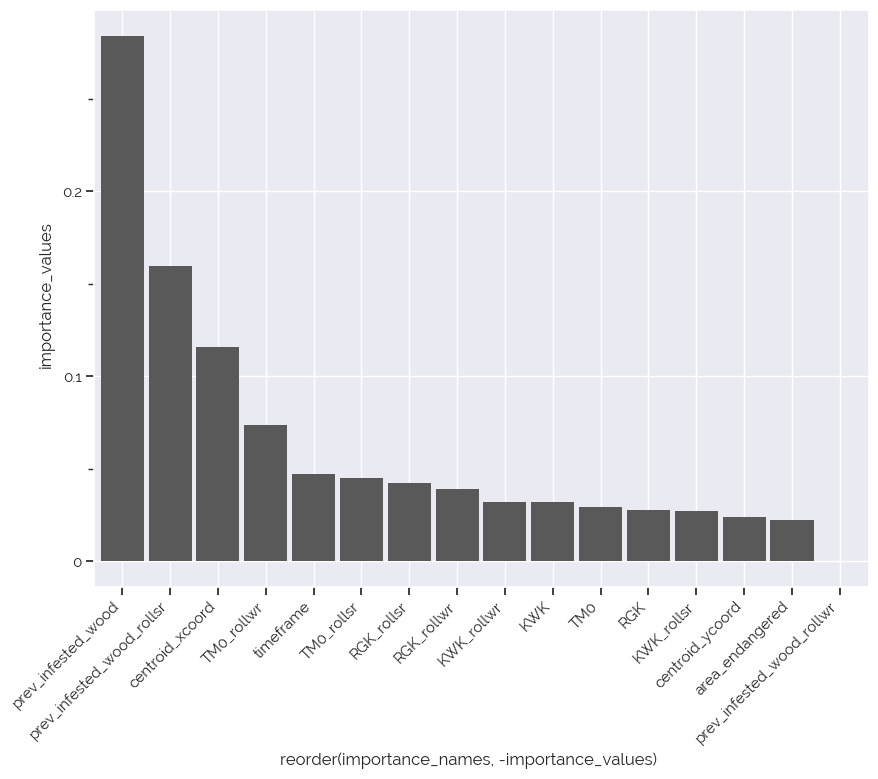

In [165]:
importance_values = best_model.feature_importances_
importance_names = X_train.columns

p9.options.figure_size = (10, 7.5)

(
    p9.ggplot()
    + p9.geom_col(p9.aes('reorder(importance_names, -importance_values)', y='importance_values'))
    + p9.theme_seaborn()
    + p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))
).draw();

In [166]:
results_df = pd.concat([X_train, X_val])
results_df['id'] = pd.concat([id_train, id_val])
results_df['timestamp'] = pd.concat([ts_train, ts_val])
results_df['y_true'] = pd.concat([y_train, y_val])
results_df['y_pred'] = np.concatenate([y_train_pred, y_val_pred])
results_df['set'] = ['train'] * X_train.shape[0] + ['validation'] * X_val.shape[0]

In [167]:
id_subset = np.random.choice(results_df['id'].unique(), 10, replace=False)

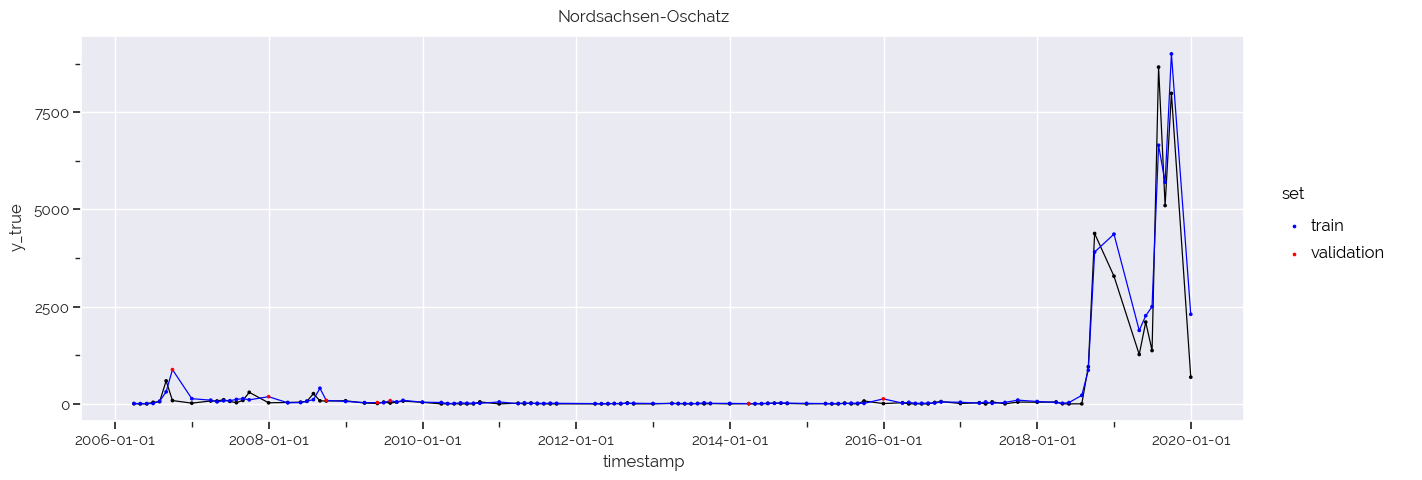

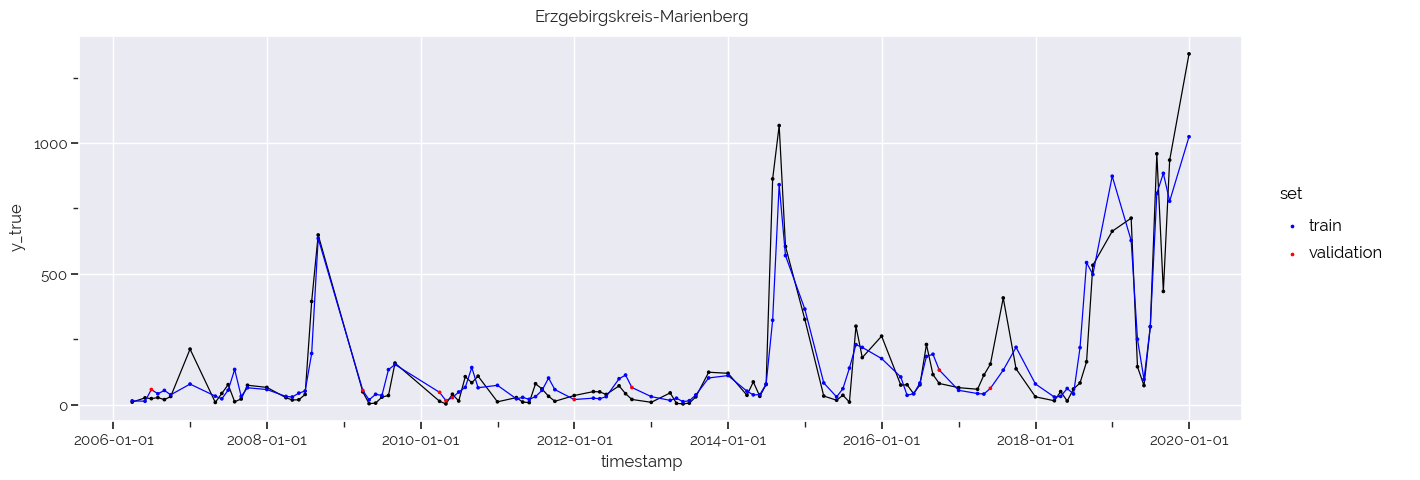

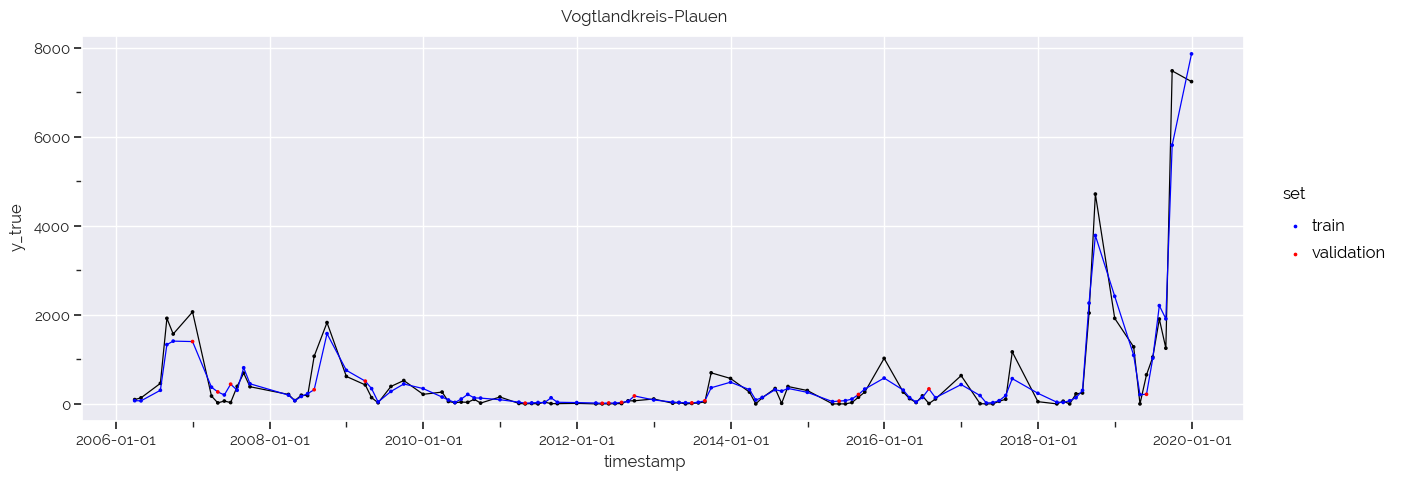

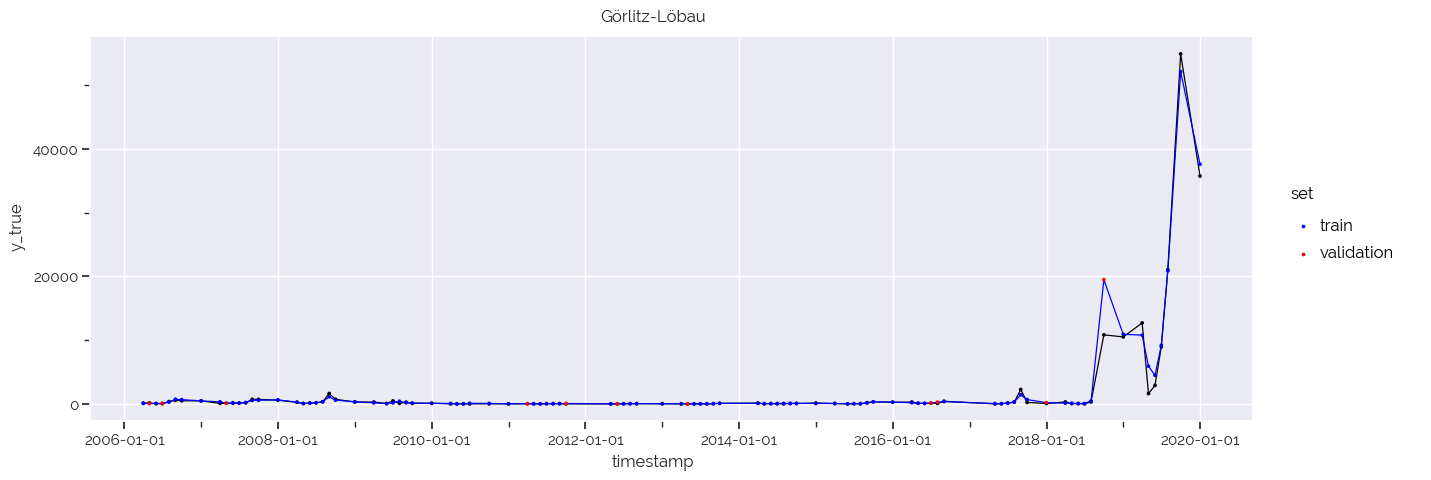

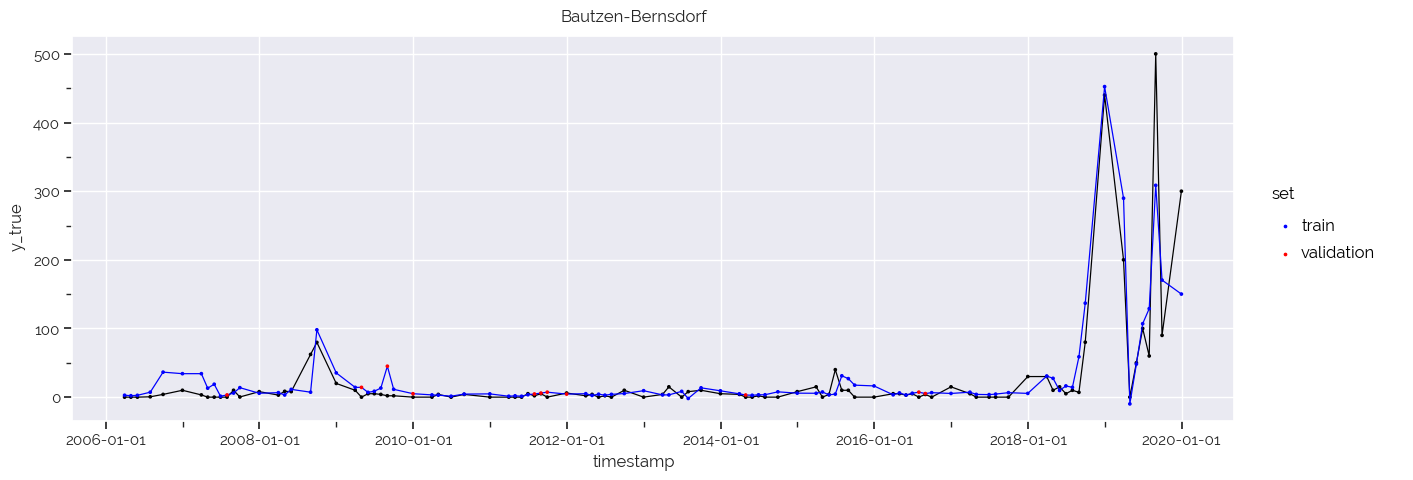

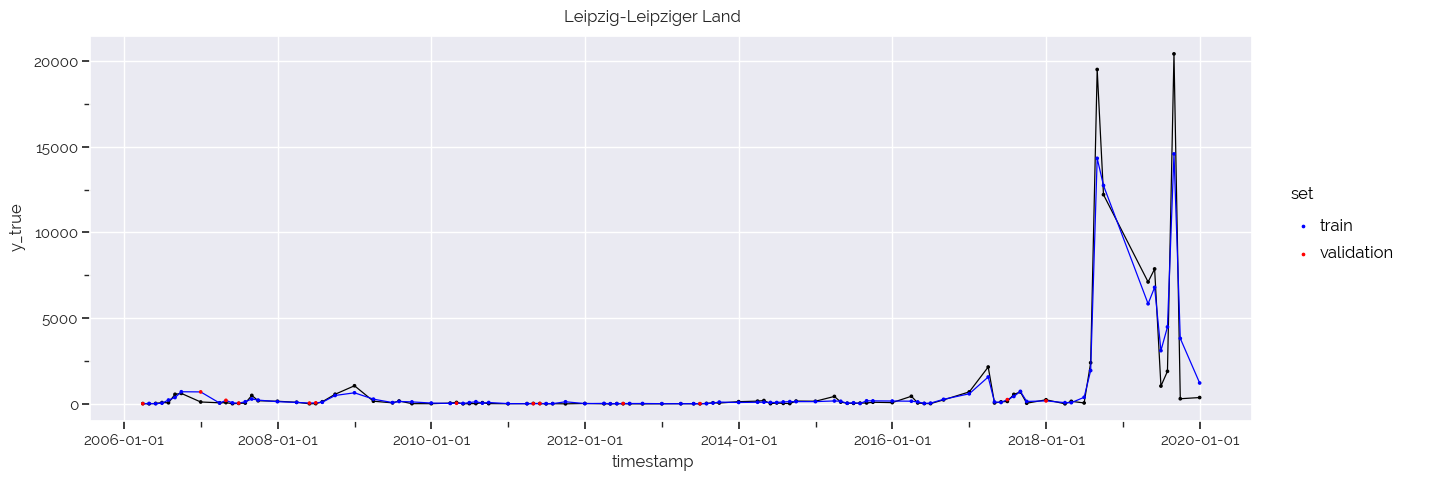

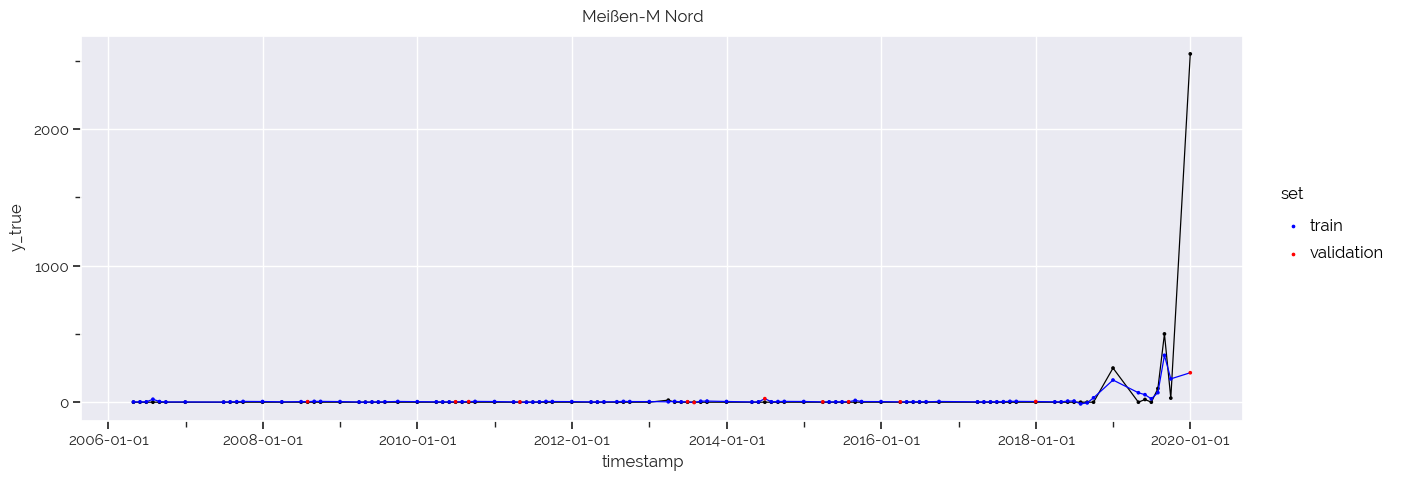

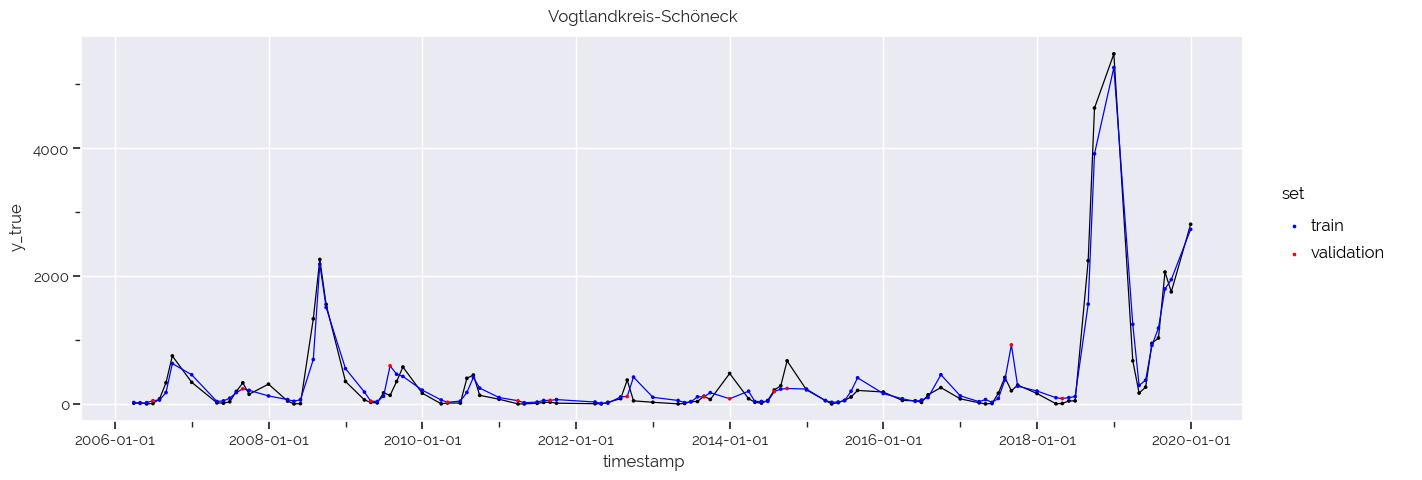

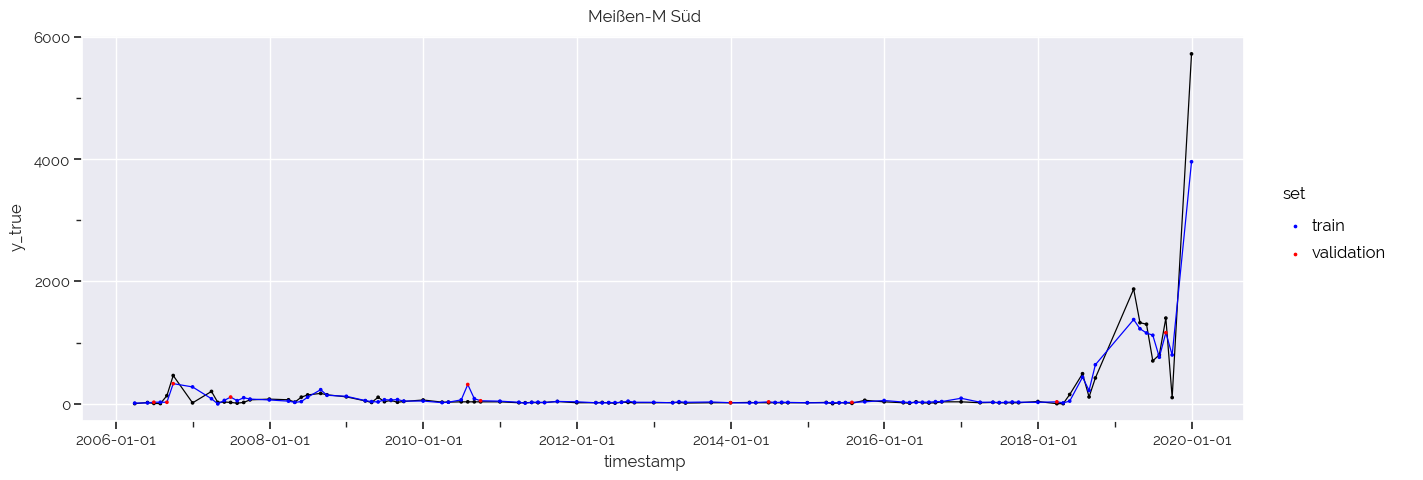

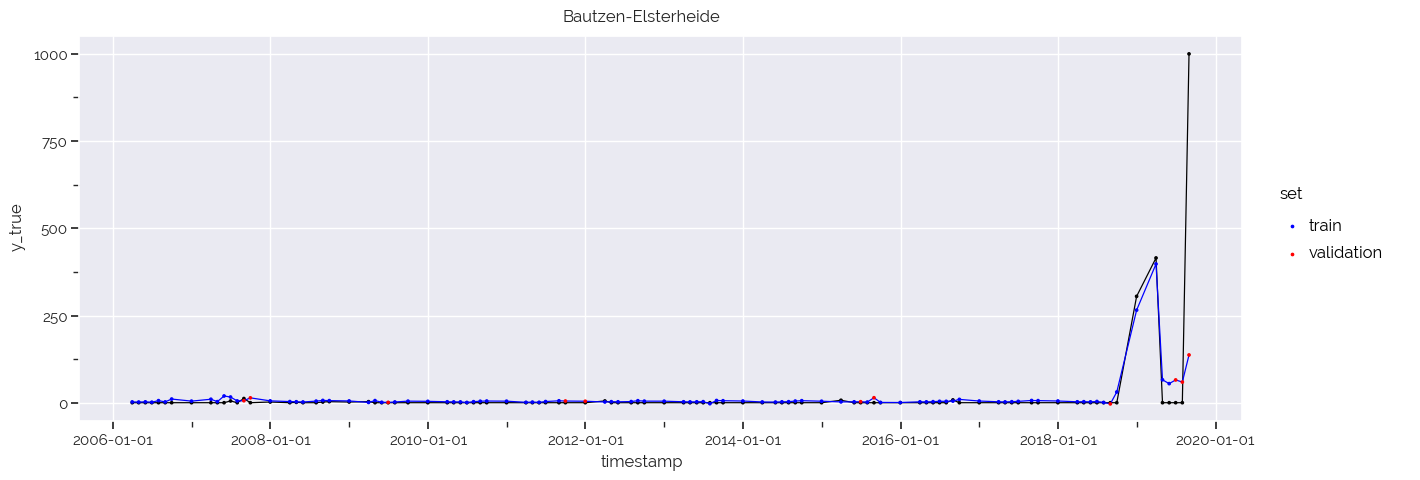

In [168]:
p9.options.figure_size = (15, 5)

for ID in id_subset:
    draw = results_df[results_df['id'] == ID]
    (
        p9.ggplot(draw)
        + p9.geom_line(p9.aes('timestamp', 'y_true'))
        + p9.geom_point(p9.aes('timestamp', 'y_true'), size=.5)
        + p9.geom_line(p9.aes('timestamp', 'y_pred'), color='blue')
        + p9.geom_point(p9.aes('timestamp', 'y_pred', color='set'), size=.5)
        + p9.scale_color_manual(['blue', 'red'])
        + p9.labels.ggtitle(ID)
        + p9.theme_seaborn()
    ).draw();